In [2]:
import json
import nltk
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean,norm
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
from gensim.models.word2vec import Word2Vec
import multiprocessing
from sklearn import utils
from keras.utils import plot_model
import pydotplus as pydot
import graphviz
import keras
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, concatenate, Activation
from keras.layers import Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model

In [ ]:
import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

In [3]:
#Read Train Dataset
tweets=pd.read_csv("D:/Thesis/Code/Data/train_data.csv")

In [ ]:
tweets.head()

In [4]:
#Data Cleaning
tok = WordPunctTokenizer()
#stop_words = set(stopwords.words('english')) 
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
pat3 = r'RT @[A-Za-z0-9_]+'
pat4 = r'RT @[A-Za-z0-9_ ] RT+'
#combined_pat = r'|'.join((pat1, pat2,pat3))
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')
rt_pattern= re.compile(pat3,flags=re.IGNORECASE)
def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    if rt_pattern.match(bom_removed):
        rt_stripped=re.sub(pat3,'',bom_removed)
        stripped = re.sub(combined_pat, '', rt_stripped)
    else:
        stripped = re.sub(combined_pat, '', bom_removed)
        stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    #tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [5]:
x = len(tweets.index)
nums = [0,x]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%525 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner_updated(tweets['text'][i]))
    clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])

Cleaning and parsing the tweets...

Tweets 525 of 5250 has been processed
Tweets 1050 of 5250 has been processed
Tweets 1575 of 5250 has been processed
Tweets 2100 of 5250 has been processed
Tweets 2625 of 5250 has been processed
Tweets 3150 of 5250 has been processed
Tweets 3675 of 5250 has been processed
Tweets 4200 of 5250 has been processed
Tweets 4725 of 5250 has been processed
Tweets 5250 of 5250 has been processed


In [6]:
clean_df['target'] = tweets.sentiment

In [ ]:
#stop = stopwords.words("english")
#clean_df['text'] = clean_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [7]:
x = clean_df.text
y = clean_df.target
SEED = 1
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.3,random_state=SEED)

In [8]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5,random_state=SEED)

In [9]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(LabeledSentence(t.split(), [prefix + '_%s' % i]))
    return result
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """


In [10]:
#Pure Distributed Bag of Words
cores = multiprocessing.cpu_count()
model_ug_dbow = Doc2Vec(dm=0, size=100, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dbow.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dbow.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dbow.alpha -= 0.002
    model_ug_dbow.min_alpha = model_ug_dbow.alpha
    
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs
  
train_vecs_dbow = get_vectors(model_ug_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_ug_dbow, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dbow, y_train)
clf.score(validation_vecs_dbow, y_validation)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1311735.03it/s]
W0825 11:28:06.916534 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<?, ?it/s]
W0825 11:28:07.096534 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<?, ?it/s]
W0825 11:28:07.274584 11428 base_any2vec.py:1386] under 10 

W0825 11:28:12.008300 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6747141041931385

In [11]:
#Pure Distributed Memory Mean
cores = multiprocessing.cpu_count()
model_ug_dmm = Doc2Vec(dm=1, dm_mean=1, size=100, window=4, negative=5, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_dmm.build_vocab([x for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_dmm.train(utils.shuffle([x for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_dmm.alpha -= 0.002
    model_ug_dmm.min_alpha = model_ug_dmm.alpha
    
train_vecs_dmm = get_vectors(model_ug_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_ug_dmm, x_validation, 100)

clf = LogisticRegression()
clf.fit(train_vecs_dmm, y_train)
clf.score(validation_vecs_dmm, y_validation)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1323084.54it/s]
W0825 11:28:12.642149 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1307451.37it/s]
W0825 11:28:12.914117 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1240219.43it/s]
W0825 11:28:13.162777 11428 base_any2vec.py:1386] under 10 

W0825 11:28:20.452237 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6759847522236341

In [12]:
#DBOW+DMM
def get_concat_vectors(model1,model2, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
        n += 1
    return vecs

train_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_train, 200)
validation_vecs_dbow_dmm = get_concat_vectors(model_ug_dbow,model_ug_dmm, x_validation, 200)

clf = LogisticRegression()
clf.fit(train_vecs_dbow_dmm, y_train)
clf.score(validation_vecs_dbow_dmm, y_validation)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6797966963151207

In [13]:
#Separate Word2Vec
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2,
                         workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1312516.90it/s]


In [14]:
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                        total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2,
                       workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]),
                      total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

def get_w2v_mean(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec
  
def get_w2v_sum(tweet, size):
    vec = np.zeros(size).reshape((1, size))
    for word in tweet.split():
        try:
            vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
        except KeyError:
            continue
    return vec
  
train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_train]))
validation_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_mean, y_train)
print(clf.score(validation_vecs_cbowsg_mean, y_validation))

train_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_sum(z, 200) for z in x_train]))
validation_vecs_cbowsg_sum = scale(np.concatenate([get_w2v_sum(z, 200) for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_cbowsg_sum, y_train)
print(clf.score(validation_vecs_cbowsg_sum, y_validation))

100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1314240.29it/s]
W0825 11:28:21.489837 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 894725.77it/s]
W0825 11:28:21.539988 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<?, ?it/s]
W0825 11:28:21.591987 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<?, ?it/s]
W0825 11:28:21.648209 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a

W0825 11:28:23.242466 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 652485.95it/s]
W0825 11:28:23.310499 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<00:00, 1323084.54it/s]
W0825 11:28:23.380506 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████████████████| 5250/5250 [00:00<?, ?it/s]
W0825 11:28:23.444346 11428 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|███████████████████████████████████████████████████████████████████

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6747141041931385


C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6734434561626429


In [15]:
#w2v general
def get_w2v_general(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [16]:
#Word vectors extracted from Doc2Vec models with custom weighting
cvec = CountVectorizer(max_features=100000)
cvec.fit(x_train)

neg_train = x_train[y_train == 0]
pos_train = x_train[y_train == 1]
neu_train = x_train[y_train == 2]
neg_doc_matrix = cvec.transform(neg_train)
pos_doc_matrix = cvec.transform(pos_train)
neu_doc_matrix = cvec.transform(neu_train)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neu_tf = np.sum(neu_doc_matrix,axis=0)

def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
neu = np.squeeze(np.asarray(neu_tf))
term_freq_df2 = pd.DataFrame([neg,pos,neu],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive','neutral']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive'] + term_freq_df2['neutral']
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
pos_hmean = term_freq_df2.pos_normcdf_hmean


#w2v_pos_hmean = {}
#for w in model_ug_dbow.wv.vocab.keys():
#    if w in pos_hmean.keys():
#        w2v_pos_hmean[w] = np.append(model_ug_dbow[w],model_ug_dmm[w]) * pos_hmean[w]
        
#train_vecs_w2v_poshmean_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'mean') for z in x_train]))
#validation_vecs_w2v_poshmean_mean = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'mean') for z in x_validation]))
#clf = LogisticRegression()
#clf.fit(train_vecs_w2v_poshmean_mean, y_train)
#print(clf.score(validation_vecs_w2v_poshmean_mean, y_validation))

#train_vecs_w2v_poshmean_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'sum') for z in x_train]))
#validation_vecs_w2v_poshmean_sum = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean, 'sum') for z in x_validation]))
#clf = LogisticRegression()
#clf.fit(train_vecs_w2v_poshmean_sum, y_train)
#print(clf.score(validation_vecs_w2v_poshmean_sum, y_validation))

In [17]:
#Separately trained Word2Vec with custom weighting (Average/Sum)
%time
w2v_pos_hmean_01 = {}
for w in model_ug_cbow.wv.vocab.keys():
    if w in pos_hmean.keys():
        w2v_pos_hmean_01[w] = np.append(model_ug_cbow[w],model_ug_sg[w]) * pos_hmean[w]
        
train_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in x_train]))
validation_vecs_w2v_poshmean_mean_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'mean') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_mean_01, y_train)
print(clf.score(validation_vecs_w2v_poshmean_mean_01, y_validation))

train_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in x_train]))
validation_vecs_w2v_poshmean_sum_01 = scale(np.concatenate([get_w2v_general(z, 200, w2v_pos_hmean_01, 'sum') for z in x_validation]))
clf = LogisticRegression()
clf.fit(train_vecs_w2v_poshmean_sum_01, y_train)
print(clf.score(validation_vecs_w2v_poshmean_sum_01, y_validation))

Wall time: 0 ns


C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6861499364675985


C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6886912325285895


In [ ]:
#model_ug_cbow.save("w2v_model_ug_cbow.word2vec")

In [ ]:
#model_ug_sg.save("w2v_model_ug_sg.word2vec")

In [ ]:
from gensim.models import KeyedVectors
#model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
#model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [18]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
x_train_seq = pad_sequences(sequences, maxlen=45)

In [20]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
length = []
for x in x_train:
    length.append(len(x.split()))
max(length)

30

In [22]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)

In [23]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [ ]:
#num_words = 100000
#embedding_matrix = np.zeros((num_words, 200))
#for word, i in tokenizer.word_index.items():
#    if i >= num_words:
#        continue
#    embedding_vector = embeddings_index.get(word)
#    if embedding_vector is not None:
#        embedding_matrix[i] = embedding_vector

In [24]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=45)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(512, activation='relu'))
model_ptw2v.add(Dense(10, activation='softmax'))
model_ptw2v.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=64, verbose=2)

W0825 11:28:32.446806 11428 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 11:28:32.458807 11428 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 11:28:32.462807 11428 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 11:28:32.494836 11428 deprecation_wrapper.py:119] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0825 11:28:32.514811 11

Train on 3675 samples, validate on 787 samples
Epoch 1/5
 - 7s - loss: 0.9268 - acc: 0.6155 - val_loss: 0.8000 - val_acc: 0.6531
Epoch 2/5
 - 4s - loss: 0.5976 - acc: 0.7624 - val_loss: 0.7469 - val_acc: 0.6989
Epoch 3/5
 - 4s - loss: 0.2025 - acc: 0.9461 - val_loss: 0.8349 - val_acc: 0.6760
Epoch 4/5
 - 4s - loss: 0.0746 - acc: 0.9812 - val_loss: 0.9105 - val_acc: 0.6925
Epoch 5/5
 - 4s - loss: 0.0519 - acc: 0.9864 - val_loss: 0.9753 - val_acc: 0.6938


In [25]:
tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(100000, 200, input_length=45, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1, name="Bigram_Convolution_Layer")(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1, name="Trigram_Convolution_Layer")(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1, name="Fourgram_Convolution_Layer")(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
merged = Dense(512, activation='relu')(merged)
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(10)(merged)
output = Activation('softmax')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

W0825 11:28:56.716414 11428 deprecation.py:506] From C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 200)      20000000    input_1[0][0]                    
__________________________________________________________________________________________________
Bigram_Convolution_Layer (Conv1 (None, 44, 100)      40100       embedding_2[0][0]                
__________________________________________________________________________________________________
Trigram_Convolution_Layer (Conv (None, 43, 100)      60100       embedding_2[0][0]                
__________________________________________________________________________________________________
Fourgram_C

In [ ]:
#plot_model(model, to_file='model.png')

In [ ]:
layers_info = {}
for i in model.layers:
    layers_info[i.name] = i.get_config()

#here the layer_weights dictionary will map every layer_name to its corresponding weights
layer_weights = {}
for i in model.layers:
    layer_weights[i.name] = i.get_weights()

#print(layers_info['activation_5'])

In [26]:
import keras.callbacks
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train_seq, y_train, batch_size=64, epochs=20,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Train on 3675 samples, validate on 787 samples
Epoch 1/20
3675/3675 [==============================] - ETA: 3:49 - loss: 2.3158 - acc: 0.109 - ETA: 1:54 - loss: 2.2203 - acc: 0.367 - ETA: 1:15 - loss: 2.1134 - acc: 0.489 - ETA: 56s - loss: 2.0071 - acc: 0.515 - ETA: 45s - loss: 1.9058 - acc: 0.52 - ETA: 37s - loss: 1.7867 - acc: 0.54 - ETA: 31s - loss: 1.7180 - acc: 0.54 - ETA: 27s - loss: 1.6408 - acc: 0.55 - ETA: 24s - loss: 1.5665 - acc: 0.57 - ETA: 21s - loss: 1.5315 - acc: 0.57 - ETA: 19s - loss: 1.4595 - acc: 0.58 - ETA: 17s - loss: 1.4185 - acc: 0.59 - ETA: 16s - loss: 1.3939 - acc: 0.59 - ETA: 15s - loss: 1.3835 - acc: 0.58 - ETA: 13s - loss: 1.3625 - acc: 0.59 - ETA: 12s - loss: 1.3421 - acc: 0.59 - ETA: 12s - loss: 1.3215 - acc: 0.59 - ETA: 11s - loss: 1.2986 - acc: 0.59 - ETA: 10s - loss: 1.2856 - acc: 0.60 - ETA: 9s - loss: 1.2677 - acc: 0.6047 - ETA: 9s - loss: 1.2573 - acc: 0.604 - ETA: 8s - loss: 1.2460 - acc: 0.606 - ETA: 8s - loss: 1.2366 - acc: 0.604 - ETA: 7s - loss:

3675/3675 [==============================] - ETA: 3s - loss: 0.3594 - acc: 0.859 - ETA: 3s - loss: 0.2717 - acc: 0.906 - ETA: 3s - loss: 0.2607 - acc: 0.906 - ETA: 3s - loss: 0.2556 - acc: 0.910 - ETA: 3s - loss: 0.2393 - acc: 0.918 - ETA: 3s - loss: 0.2141 - acc: 0.929 - ETA: 3s - loss: 0.2193 - acc: 0.928 - ETA: 3s - loss: 0.2055 - acc: 0.937 - ETA: 3s - loss: 0.2002 - acc: 0.939 - ETA: 3s - loss: 0.2057 - acc: 0.934 - ETA: 3s - loss: 0.1977 - acc: 0.938 - ETA: 3s - loss: 0.1984 - acc: 0.941 - ETA: 3s - loss: 0.1934 - acc: 0.943 - ETA: 3s - loss: 0.1886 - acc: 0.946 - ETA: 3s - loss: 0.1821 - acc: 0.947 - ETA: 3s - loss: 0.1835 - acc: 0.948 - ETA: 3s - loss: 0.1768 - acc: 0.950 - ETA: 3s - loss: 0.1762 - acc: 0.951 - ETA: 2s - loss: 0.1820 - acc: 0.949 - ETA: 2s - loss: 0.1811 - acc: 0.949 - ETA: 2s - loss: 0.1871 - acc: 0.945 - ETA: 2s - loss: 0.1831 - acc: 0.946 - ETA: 2s - loss: 0.1840 - acc: 0.946 - ETA: 2s - loss: 0.1900 - acc: 0.945 - ETA: 2s - loss: 0.1895 - acc: 0.945 - ETA: 

3675/3675 [==============================] - ETA: 3s - loss: 0.0108 - acc: 1.000 - ETA: 3s - loss: 0.0135 - acc: 1.000 - ETA: 3s - loss: 0.0159 - acc: 0.994 - ETA: 3s - loss: 0.0166 - acc: 0.996 - ETA: 3s - loss: 0.0155 - acc: 0.996 - ETA: 3s - loss: 0.0219 - acc: 0.992 - ETA: 3s - loss: 0.0201 - acc: 0.993 - ETA: 3s - loss: 0.0240 - acc: 0.992 - ETA: 3s - loss: 0.0233 - acc: 0.993 - ETA: 3s - loss: 0.0283 - acc: 0.990 - ETA: 3s - loss: 0.0327 - acc: 0.990 - ETA: 3s - loss: 0.0389 - acc: 0.989 - ETA: 3s - loss: 0.0364 - acc: 0.990 - ETA: 3s - loss: 0.0346 - acc: 0.991 - ETA: 3s - loss: 0.0347 - acc: 0.990 - ETA: 3s - loss: 0.0328 - acc: 0.991 - ETA: 3s - loss: 0.0311 - acc: 0.991 - ETA: 3s - loss: 0.0316 - acc: 0.991 - ETA: 2s - loss: 0.0309 - acc: 0.991 - ETA: 2s - loss: 0.0316 - acc: 0.991 - ETA: 2s - loss: 0.0305 - acc: 0.991 - ETA: 2s - loss: 0.0315 - acc: 0.991 - ETA: 2s - loss: 0.0305 - acc: 0.991 - ETA: 2s - loss: 0.0319 - acc: 0.991 - ETA: 2s - loss: 0.0408 - acc: 0.990 - ETA: 

3675/3675 [==============================] - ETA: 3s - loss: 0.0178 - acc: 1.000 - ETA: 3s - loss: 0.0219 - acc: 0.992 - ETA: 3s - loss: 0.0156 - acc: 0.994 - ETA: 3s - loss: 0.0125 - acc: 0.996 - ETA: 3s - loss: 0.0107 - acc: 0.996 - ETA: 3s - loss: 0.0095 - acc: 0.997 - ETA: 3s - loss: 0.0178 - acc: 0.993 - ETA: 3s - loss: 0.0160 - acc: 0.994 - ETA: 3s - loss: 0.0146 - acc: 0.994 - ETA: 3s - loss: 0.0188 - acc: 0.993 - ETA: 3s - loss: 0.0175 - acc: 0.994 - ETA: 3s - loss: 0.0163 - acc: 0.994 - ETA: 3s - loss: 0.0153 - acc: 0.995 - ETA: 3s - loss: 0.0184 - acc: 0.994 - ETA: 3s - loss: 0.0187 - acc: 0.993 - ETA: 3s - loss: 0.0177 - acc: 0.994 - ETA: 3s - loss: 0.0202 - acc: 0.993 - ETA: 3s - loss: 0.0193 - acc: 0.993 - ETA: 3s - loss: 0.0223 - acc: 0.993 - ETA: 2s - loss: 0.0213 - acc: 0.993 - ETA: 2s - loss: 0.0217 - acc: 0.993 - ETA: 2s - loss: 0.0212 - acc: 0.993 - ETA: 2s - loss: 0.0222 - acc: 0.993 - ETA: 2s - loss: 0.0214 - acc: 0.993 - ETA: 2s - loss: 0.0246 - acc: 0.992 - ETA: 

3675/3675 [==============================] - ETA: 4s - loss: 0.0127 - acc: 1.000 - ETA: 3s - loss: 0.0106 - acc: 1.000 - ETA: 3s - loss: 0.0085 - acc: 1.000 - ETA: 3s - loss: 0.0069 - acc: 1.000 - ETA: 3s - loss: 0.0058 - acc: 1.000 - ETA: 3s - loss: 0.0050 - acc: 1.000 - ETA: 3s - loss: 0.0050 - acc: 1.000 - ETA: 3s - loss: 0.0052 - acc: 1.000 - ETA: 3s - loss: 0.0050 - acc: 1.000 - ETA: 3s - loss: 0.0078 - acc: 0.998 - ETA: 3s - loss: 0.0084 - acc: 0.998 - ETA: 3s - loss: 0.0082 - acc: 0.998 - ETA: 3s - loss: 0.0128 - acc: 0.996 - ETA: 3s - loss: 0.0121 - acc: 0.996 - ETA: 3s - loss: 0.0118 - acc: 0.996 - ETA: 3s - loss: 0.0156 - acc: 0.995 - ETA: 3s - loss: 0.0155 - acc: 0.995 - ETA: 3s - loss: 0.0161 - acc: 0.994 - ETA: 2s - loss: 0.0157 - acc: 0.995 - ETA: 2s - loss: 0.0157 - acc: 0.994 - ETA: 2s - loss: 0.0151 - acc: 0.994 - ETA: 2s - loss: 0.0159 - acc: 0.994 - ETA: 2s - loss: 0.0156 - acc: 0.994 - ETA: 2s - loss: 0.0153 - acc: 0.994 - ETA: 2s - loss: 0.0152 - acc: 0.995 - ETA: 

3675/3675 [==============================] - ETA: 3s - loss: 0.0137 - acc: 1.000 - ETA: 3s - loss: 0.0352 - acc: 0.992 - ETA: 4s - loss: 0.0337 - acc: 0.989 - ETA: 4s - loss: 0.0387 - acc: 0.988 - ETA: 3s - loss: 0.0313 - acc: 0.990 - ETA: 3s - loss: 0.0338 - acc: 0.989 - ETA: 3s - loss: 0.0292 - acc: 0.991 - ETA: 3s - loss: 0.0274 - acc: 0.990 - ETA: 3s - loss: 0.0250 - acc: 0.991 - ETA: 3s - loss: 0.0306 - acc: 0.989 - ETA: 3s - loss: 0.0287 - acc: 0.990 - ETA: 3s - loss: 0.0274 - acc: 0.990 - ETA: 3s - loss: 0.0254 - acc: 0.991 - ETA: 3s - loss: 0.0237 - acc: 0.992 - ETA: 3s - loss: 0.0222 - acc: 0.992 - ETA: 3s - loss: 0.0218 - acc: 0.992 - ETA: 3s - loss: 0.0211 - acc: 0.992 - ETA: 3s - loss: 0.0200 - acc: 0.993 - ETA: 2s - loss: 0.0199 - acc: 0.992 - ETA: 2s - loss: 0.0200 - acc: 0.992 - ETA: 2s - loss: 0.0194 - acc: 0.992 - ETA: 2s - loss: 0.0188 - acc: 0.992 - ETA: 2s - loss: 0.0187 - acc: 0.992 - ETA: 2s - loss: 0.0183 - acc: 0.992 - ETA: 2s - loss: 0.0192 - acc: 0.991 - ETA: 

3675/3675 [==============================] - ETA: 3s - loss: 0.0506 - acc: 0.968 - ETA: 3s - loss: 0.0255 - acc: 0.984 - ETA: 3s - loss: 0.0175 - acc: 0.989 - ETA: 3s - loss: 0.0133 - acc: 0.992 - ETA: 3s - loss: 0.0107 - acc: 0.993 - ETA: 3s - loss: 0.0125 - acc: 0.992 - ETA: 3s - loss: 0.0140 - acc: 0.991 - ETA: 3s - loss: 0.0149 - acc: 0.992 - ETA: 3s - loss: 0.0133 - acc: 0.993 - ETA: 3s - loss: 0.0124 - acc: 0.993 - ETA: 3s - loss: 0.0125 - acc: 0.992 - ETA: 3s - loss: 0.0129 - acc: 0.992 - ETA: 3s - loss: 0.0124 - acc: 0.992 - ETA: 3s - loss: 0.0128 - acc: 0.993 - ETA: 3s - loss: 0.0139 - acc: 0.992 - ETA: 3s - loss: 0.0146 - acc: 0.992 - ETA: 3s - loss: 0.0141 - acc: 0.992 - ETA: 3s - loss: 0.0141 - acc: 0.992 - ETA: 2s - loss: 0.0142 - acc: 0.991 - ETA: 2s - loss: 0.0140 - acc: 0.992 - ETA: 2s - loss: 0.0135 - acc: 0.992 - ETA: 2s - loss: 0.0145 - acc: 0.992 - ETA: 2s - loss: 0.0154 - acc: 0.991 - ETA: 2s - loss: 0.0148 - acc: 0.991 - ETA: 2s - loss: 0.0147 - acc: 0.991 - ETA: 

In [27]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.08-0.72.hdf5')

In [58]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test, verbose=1)

788/788 [==============================] - ETA:  - ETA:  - 0s 86us/step


[1.4783670575485617, 0.6827411161461457]

In [29]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

In [74]:
yhat_cnn

array([[4.40916574e-06, 1.50800953e-02, 9.84915495e-01, ...,
        2.35519182e-09, 6.40978104e-10, 1.23177168e-09],
       [7.12016044e-05, 1.65791926e-03, 9.98270750e-01, ...,
        1.27881084e-08, 5.29144994e-09, 7.75839215e-09],
       [1.17603655e-03, 2.68904995e-02, 9.71855998e-01, ...,
        1.02228205e-05, 5.67871166e-06, 7.54883422e-06],
       ...,
       [2.70784344e-03, 2.60695769e-03, 9.94682968e-01, ...,
        2.64610861e-07, 1.26085084e-07, 1.42572318e-07],
       [3.29724967e-01, 5.18000536e-02, 6.09850109e-01, ...,
        1.16337650e-03, 8.35906132e-04, 8.00245209e-04],
       [1.87205784e-02, 9.64144647e-01, 1.71330422e-02, ...,
        4.28103846e-07, 9.91227367e-08, 1.58598098e-07]], dtype=float32)

In [30]:
from sklearn.metrics import roc_curve, auc
n_classes=3
y = label_binarize(y_test, classes=[0,1,2])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], yhat_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

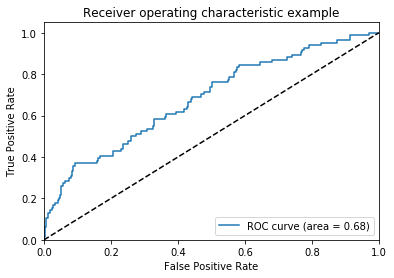

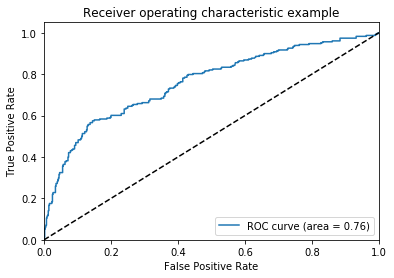

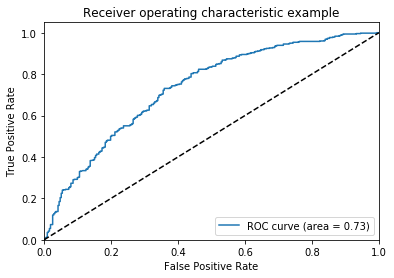

In [31]:
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x_seq = pad_sequences(sequences, maxlen=45)

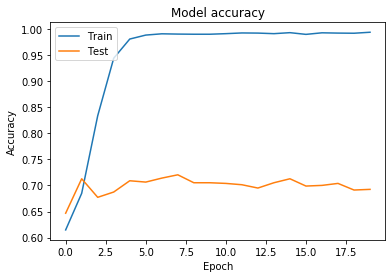

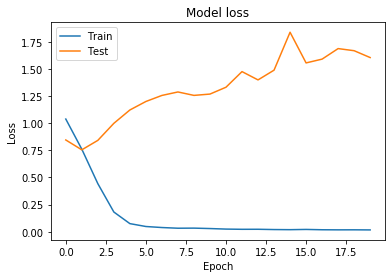

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#from sklearn.manifold import TSNE
#conv_embds = model.layers[1].get_weights()[0]
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)
## Visualize words in two dimensions 
#conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)
#plot_words(conv_tsne_embds, 0, 500, 1)

In [204]:
x_test[x_test.str.contains("Not")]

980     Unmanned, But Not Unwatched ##transportation #...
1021    RT @JeroenBartelse: Driverless Cars May Be Com...
1027    RT @JeroenBartelse: Driverless Cars May Be Com...
1030    Driverless Cars May Be Coming, but Let’s Not G...
1039    RT @JeroenBartelse: Driverless Cars May Be Com...
1074    RT @JeroenBartelse: Driverless Cars May Be Com...
1207    RT @JeroenBartelse: Driverless Cars May Be Com...
1214    RT @JeroenBartelse: Driverless Cars May Be Com...
1250    RT @JeroenBartelse: Driverless Cars May Be Com...
1263    #DriverlessCars May Be Coming, but Let’s Not G...
1264    RT @guidaautonoma: #DriverlessCars May Be Comi...
1265    RT @guidaautonoma: #DriverlessCars May Be Comi...
1266    RT @guidaautonoma: #DriverlessCars May Be Comi...
1296    RT @JeroenBartelse: Driverless Cars May Be Com...
1359    RT @guidaautonoma: #DriverlessCars May Be Comi...
1388    RT @guidaautonoma: #DriverlessCars May Be Comi...
1390    RT @guidaautonoma: #DriverlessCars May Be Comi...
1420    RT @gu

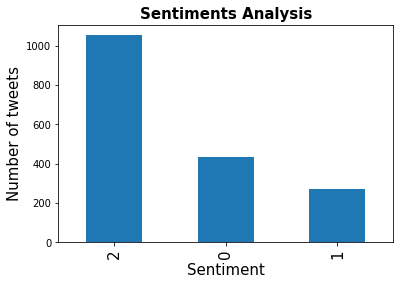

In [189]:
tweets_by_lang = y_test.value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Sentiment', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Sentiments Analysis', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar')

Text(0.5, 1.0, 'Top 500 tokens in tweets')

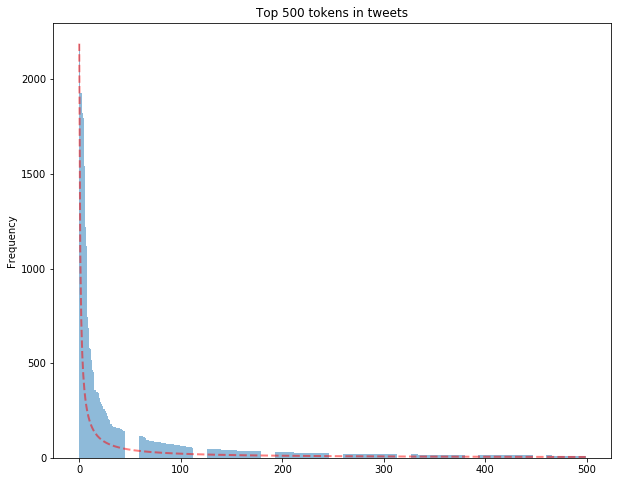

In [40]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df2.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df2.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

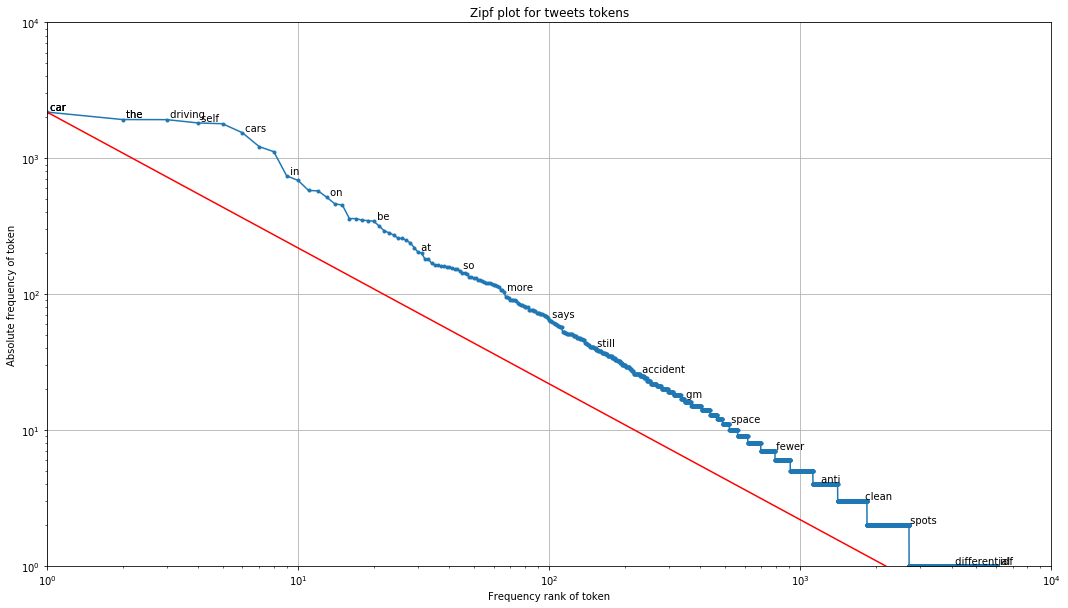

In [53]:
from pylab import *
counts = term_freq_df2.total
tokens = term_freq_df2.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(18,10))
plt.ylim(1,10**4)
plt.xlim(1,10**4)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Text(0.5, 1.0, 'Top 20 tokens in positive tweets')

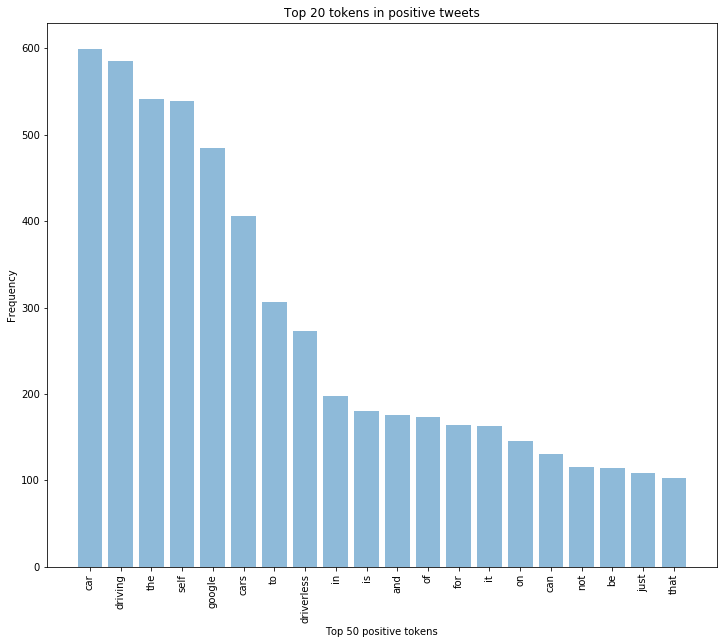

In [47]:
y_pos = np.arange(20)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:20], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:20].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 20 tokens in positive tweets')

Text(0.5, 1.0, 'Top 20 tokens in negative tweets')

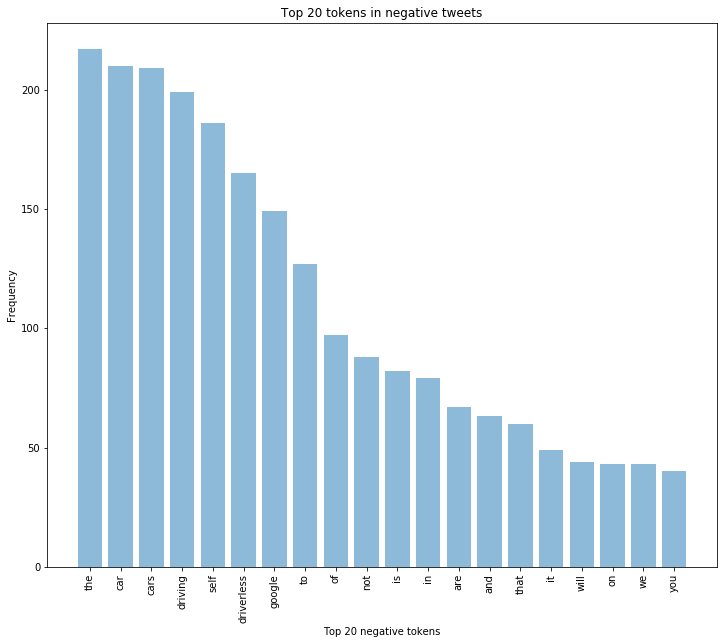

In [205]:
y_neg = np.arange(20)
plt.figure(figsize=(12,10))
plt.bar(y_neg, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:20], align='center', alpha=0.5)
plt.xticks(y_neg, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:20].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 20 negative tokens')
plt.title('Top 20 tokens in negative tweets')

### Test DataSet Work

In [60]:
#For Reading Test Dataset
def read_data(tweets_data_path):
    tweets_data = []
    tweets_file = open(tweets_data_path, "r")
    line = tweets_file.readline()
    for line in tweets_file:
        try:
            tweet = json.loads(line)
            tweets_data.append(tweet)
        except:
            continue
    data = pd.DataFrame.from_dict(tweets_data)
    return data

In [109]:
#Read Test Dataset
tweet_data=read_data("D:/Thesis/autonomousDriveMulti.json")
tweet_data1=read_data("D:/Thesis/autonomousDrive.json")
tweet_data2=read_data("D:/Thesis/python.json")
tweets= pd.concat([tweet_data, tweet_data1,tweet_data2], ignore_index=True)

C:\Users\Asus FX504\.conda\envs\tensor\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [110]:
tweets

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,quoted_status_permalink,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user
0,None,None,Mon Jul 01 23:20:20 +0000 2019,"[0, 90]","{'hashtags': [{'text': 'autonomouscars', 'indi...","{'media': [{'id': 1145834550574092290, 'id_str...",NaN,0,False,low,...,NaN,0,0,False,NaN,"<a href=""http://twibble.io"" rel=""nofollow"">Twi...",自動運転で機械式駐車場へ 群大と新明和、入庫に成功 https://t.co/4vBo9J0...,1562023220365,False,"{'id': 308269038, 'id_str': '308269038', 'name..."
1,None,None,Mon Jul 01 23:21:08 +0000 2019,NaN,"{'hashtags': [{'text': 'ComputerVision', 'indi...",NaN,NaN,0,False,low,...,NaN,0,0,False,{'created_at': 'Sat Jun 29 17:07:00 +0000 2019...,"<a href=""https://m1.t7w.co"" rel=""nofollow"">T7 ...",RT @Paula_Piccard: Cruise is testing emergency...,1562023268604,False,"{'id': 1142490506720497664, 'id_str': '1142490..."
2,None,None,Mon Jul 01 23:25:58 +0000 2019,"[0, 140]","{'hashtags': [{'text': '5G', 'indices': [0, 3]...",NaN,{'full_text': '#5G dwarfs #4G speeds with 10x ...,0,False,low,...,NaN,0,0,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",#5G dwarfs #4G speeds with 10x increases (10 t...,1562023558770,True,"{'id': 794815, 'id_str': '794815', 'name': 'Al..."
3,None,None,Mon Jul 01 23:27:11 +0000 2019,NaN,"{'hashtags': [{'text': '5G', 'indices': [14, 1...",NaN,NaN,0,False,low,...,NaN,0,0,False,{'created_at': 'Mon Jul 01 23:25:58 +0000 2019...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @alvinfoo: #5G dwarfs #4G speeds with 10x i...,1562023631628,False,"{'id': 13584132, 'id_str': '13584132', 'name':..."
4,None,None,Mon Jul 01 23:27:25 +0000 2019,NaN,"{'hashtags': [{'text': '5G', 'indices': [14, 1...",NaN,NaN,0,False,low,...,NaN,0,0,False,{'created_at': 'Mon Jul 01 23:25:58 +0000 2019...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @alvinfoo: #5G dwarfs #4G speeds with 10x i...,1562023645144,False,"{'id': 3131243261, 'id_str': '3131243261', 'na..."
5,None,None,Mon Jul 01 23:29:49 +0000 2019,NaN,"{'hashtags': [{'text': '5G', 'indices': [14, 1...",NaN,NaN,0,False,low,...,NaN,0,0,False,{'created_at': 'Mon Jul 01 23:25:58 +0000 2019...,"<a href=""http://twitter.com/download/android"" ...",RT @alvinfoo: #5G dwarfs #4G speeds with 10x i...,1562023789370,False,"{'id': 336013958, 'id_str': '336013958', 'name..."
6,None,None,Mon Jul 01 23:30:04 +0000 2019,NaN,"{'hashtags': [{'text': 'SelfDrivingCars', 'ind...",NaN,{'full_text': 'Intel Corp.’s Mobileye NV unit ...,0,False,low,...,NaN,0,0,False,NaN,"<a href=""http://www.linkedin.com/"" rel=""nofoll...",Intel Corp.’s Mobileye NV unit expects to laun...,1562023804767,True,"{'id': 94601315, 'id_str': '94601315', 'name':..."
7,None,None,Mon Jul 01 23:30:52 +0000 2019,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,low,...,"{'url': 'https://t.co/8q1cpTTz4d', 'expanded':...",0,0,False,NaN,"<a href=""http://twitter.com/download/android"" ...","Some fanboys were going who needs 5G anyway, a...",1562023852292,False,"{'id': 336013958, 'id_str': '336013958', 'name..."
8,None,None,Mon Jul 01 23:32:40 +0000 2019,NaN,"{'hashtags': [{'text': 'autonomousvehicles', '...",NaN,NaN,0,False,low,...,NaN,0,0,False,{'created_at': 'Mon Jul 01 21:52:37 +0000 2019...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @nvidiadrive: Safety is what drives us. And...,1562023960547,False,"{'id': 2660575303, 'id_str': '2660575303', 'na..."
9,None,None,Mon Jul 01 23:34:19 +0000 2019,NaN,"{'hashtags': [{'text': '5G', 'indices': [14, 1...",NaN,NaN,0,False,low,...,NaN,0,0,False,{'created_at': 'Mon Jul 01 23:25:58 +0000 2019...,"<a href=""http://twitter.com/download/iphone"" r...",RT @alvinfoo: #5G dwarfs #4G speeds with 10x i...,1562024059014,False,"{'id': 904814997334839297, 'id_str': '90481499..."


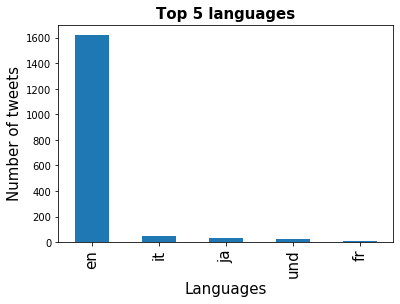

In [135]:
#For Test Dataset Only
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar')

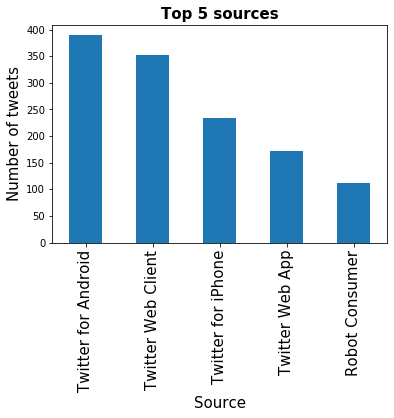

In [137]:
#For Test Dataset Only
tweets_by_lang = tweets['source'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Source', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 sources', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar')

In [113]:
#Conversion to xlsx (optional)
writer = ExcelWriter('tweets.xlsx')
tweets.to_excel(writer,'Sheet1')
writer.save()

In [175]:
tweets=pd.read_excel("D:/Thesis/Code/Data/tweets.xlsx")

In [176]:
#For Test Dataset Only
tweets['created_at'] = pd.to_datetime(tweets.created_at)
tweets['source'] = tweets['source'].str.extract('>(.+?)<', expand=False).str.strip()
tweets['pre_clean_len'] = [len(t) for t in tweets.text]

In [177]:
#Test Data Clean
x = len(tweets.index)
nums = [0,x]
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%881 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
    clean_tweet_texts.append(tweet_cleaner_updated(tweets['text'][i]))
    clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])

Cleaning and parsing the tweets...

Tweets 881 of 1761 has been processed


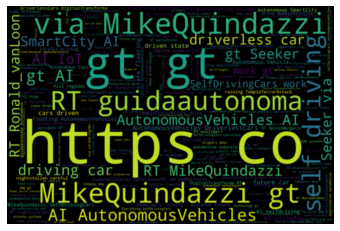

In [117]:
text = " ".join(message for message in tweets.text)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2400, height = 1600).generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='gaussian')
plt.axis("off")
plt.show()

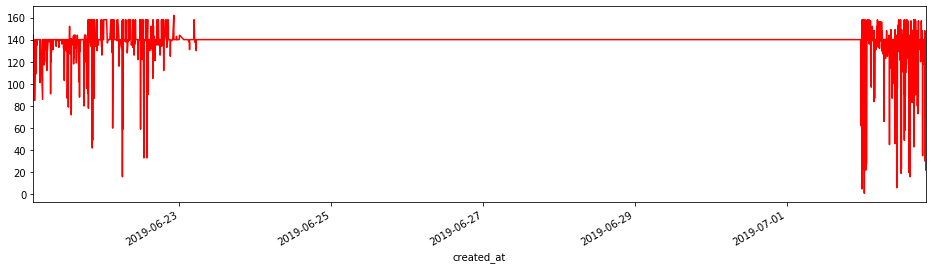

In [155]:
time_len=pd.Series(data=tweets['pre_clean_len'].values, index=tweets['created_at'])
time_len.plot(figsize=(16, 4), color='r')
plt.show()

In [178]:
x_test= tweets['text']

In [179]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)
y_test= tweets['sentiment']

In [180]:
y_proba=model.predict(x_test_seq)
y_classes = y_proba.argmax(axis=-1)

In [181]:
model.evaluate(x=x_test_seq, y=y_test, verbose=1)

1761/1761 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 100us/step


[1.6589227223388778, 0.8188529244747302]

In [182]:
y_classes=pd.Series(y_classes)

In [183]:
y_test=pd.Series(y_test)

In [184]:
y_classes==y_test

0       False
1        True
2        True
3        True
4        True
        ...  
1756     True
1757     True
1758     True
1759     True
1760     True
Length: 1761, dtype: bool

# END